# Install the below dependencies

In [127]:
##Run the below block to initialize all the dependencies
import requests
from pprint import pprint
import pandas as pd
from pandas import ExcelWriter
import io, time, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy
import warnings
import io, time, json
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk import punkt
import wordcloud
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [15]:
##The below block of code is used to read the API Key required for extracting data from Yelp fusion API.

def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

def read_api_key_zomato(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key_zomato.txt', 'r') as f:
        return f.read().replace('\n','')

# Yelp Data Extraction

In [30]:
##The function below is used to retrieve all the restaurants from the YELP API.

def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    
    offsetno=0
    total =0
    output=[]
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    while (offsetno < 1000):
        params = { #parameters are case sensitive!
            "location": query,
            "limit": 20,
            "offset": offsetno,
            "categories": "restaurants"
            
        }
    
        response = requests.get('https://api.yelp.com/v3/businesses/search',
                            headers=headers, params=params)
        result = response.json()
        try:
            output.append( result['businesses'])
        except KeyError:
            print(result)
            return output
        offsetno =offsetno + 20
        total = result['total']
        #print (offsetno)
        #print (len(output))
    return(output)

api_key = read_api_key('api_key.txt')
data = all_restaurants(api_key, 'Miami')
new_data = {}
new_data["name"]=[]
new_data["rating"]=[]
new_data["price"]=[]
new_data["review_count"]=[]
new_data["url"]=[]
new_data["category"]=[]
new_data["zip"]=[]
alldata=[]
ids=[]
name=[]
zips=[]
for i in data:
    for each in i:
        new_data["name"].append(each["name"])
        new_data["rating"].append(each["rating"])
        new_data["url"].append(each["url"])
        try:
            new_data["price"].append(each["price"])
        except KeyError:
            new_data["price"].append(None)

        new_data["review_count"].append(each["review_count"])
        new_data["category"].append(each["categories"][0]["title"])
        new_data["zip"].append(each["location"]["zip_code"])
        ids.append(each["id"])
        name.append(each["name"])
        zips.append(each["location"]["zip_code"])
        alldata.append(each)
writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')
yelp_raw = pd.DataFrame(alldata)
yelp_clean = pd.DataFrame(new_data)
yelp_clean['source'] = 'Yelp'

In [ ]:
'''
The below peice of code is executed to extract the actual value for prices. This is mandatory to ensure 
that prices have integer values and can be used for visualization later.
'''

def price(df):
    try:
        df["price"]= len(df["price"])
    except:
        df["price"]=""
    return df
yelp_clean= yelp_clean.apply(price,axis=1)

In [118]:
'''
The below function hits the YELP Fusion API again and fetches reviews for the restaurants that were fetched in the 
above query. This function is being called in the code block below and the data extracted is being used
in generating the word cloud.
''' 

def get_reviews(ids,name):
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    restau_names=[]
    output=[]
    for i in range(len(ids)):
        params = { #parameters are case sensitive!
            "locale": "en_US",
        }
        url = "https://api.yelp.com/v3/businesses/"+str(ids[i])+"/reviews"
        response = requests.get(url,
                            headers=headers,params=params)
        result = response.json()
        output.append(result["reviews"])
        restau_names.append(name[i])
    return output,restau_names

In [85]:
##Calling the function above and storing the Restaurant Name and Reviews in seperate lists

reviews, restau_name = get_reviews(ids,name)

In [86]:
'''
Writing the data fetched in the above block to a CSV, since the API call is time consuming and can be an
expensive operation to be run consecutively. 
The CSV acts as a one time data store for reviews.
'''

restau=[]
text_reviews=[]
loc_zip=[]
for i in range(len(reviews)):
    for each in reviews[i]:
        text_reviews.append(each["text"])
#         print(i)
        restau.append(name[i])
        loc_zip.append(zips[i])
d = {'restau_name':restau,'zip':loc_zip,'reviews':text_reviews}
reviews_df = pd.DataFrame(d)
reviews_df.to_csv("../DataFiles/reviews_df.csv",index=False)

# Trip Advisor Data Cleaning

In [46]:
##The below code needs to be executed to clean the TripAdvisor CSV file and create a raw and clean dataset out of it.

trip_advisor_raw = pd.read_csv('../DataFiles/TripAdvisor_Data.csv')
trip_advisor_clean = trip_advisor_raw[trip_advisor_raw["City"]=="Miami"]
trip_advisor_clean = trip_advisor_clean.loc[:,["Name","Ranking","Price","Total Review","Restaurant URL","cuisine","Address",]]
trip_advisor_clean.rename(index=str,columns={"Name":"name","Ranking":"rating","Total Review":"review_count","Restaurant URL":"url","cuisine":"category","Price":"price"},inplace=True)
trip_advisor_clean['source'] = 'Trip Advisor'
trip_advisor_clean["check"] = trip_advisor_clean["Address"].str[-5:].str.isdigit()
trip_advisor_clean = trip_advisor_clean[~trip_advisor_clean.Address.isnull()]

In [47]:
'''
The Zip code is Trip Advisor needs to be extracted from the address to maintain a uniformity in the cleaned data.
The below function returns the extracted zip from the address based on whether the address has a Zip or not.
'''

def check(df):
    try:
        if df["check"]==False:
            df["new_zip"]=""
        if df["check"]==True and df["Address"][-10:].find("-")==-1:
            df["new_zip"]=df["Address"][-5:]
        if df["check"]==False and df["Address"][-10:].find("-")!=-1:
            df["new_zip"]= df["Address"][-10:][:df["Address"][-10:].find("-")]
    except AttributeError: 
        df["new_zip"]=""
    except TypeError:
        df["new_zip"]=""
        
    return df

In [48]:
## Calling the check function on the previously cleaned data.

trip_advisor_clean= trip_advisor_clean.apply(check, axis=1)

In [49]:
##Since we need to maintain a uniformity in cleaned data to Address and check columns are dropped.
##At the same time new zip column is renamed to zip

trip_advisor_clean.drop(columns=['Address', 'check'],inplace=True)
trip_advisor_clean.rename(columns={"new_zip":"zip"},inplace=True)

# Zomato Data Extraction

In [21]:
##Below block of code is used to extract the data from the Zomato API.

api_key_zomato = read_api_key_zomato('api_key_zomato.txt')

headers = {'Content-Type': 'application/json', 'user-key': api_key_zomato}
offset = 0
restaurantNameList = []
ratingList = []
votesList = []
urlList = []
categoryList = []
priceList = []
zipList = []
totalData = []
while offset < 100:
    url = 'https://developers.zomato.com/api/v2.1/search?entity_id=291&entity_type=city&start='+str(offset)+'&count=20'
    Response = requests.get(url , headers=headers)
    offset += 20
    Response_Json = Response.json()
    Array_length = Response_Json['restaurants']
    for i in range(len(Array_length)):
        totalData.append(Response_Json['restaurants'][i])
        restaurantNameList.append(Response_Json['restaurants'][i]['restaurant']['name'])
        ratingList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
        votesList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['votes'])
        urlList.append(Response_Json['restaurants'][i]['restaurant']['url'])
        categoryList.append(Response_Json['restaurants'][i]['restaurant']['cuisines'])
        priceList.append(Response_Json['restaurants'][i]['restaurant']['average_cost_for_two'])
        zipList.append(Response_Json['restaurants'][i]['restaurant']['location']['zipcode'])
zomato_raw = pd.DataFrame({'AllData':totalData})
zomato_clean = pd.DataFrame({'name':restaurantNameList,'rating':ratingList,'price':priceList ,'review_count':votesList,'url':urlList,'category':categoryList,'zip':zipList})
zomato_clean['source'] = 'Zomato'

In [59]:
##The below code will merge all the data frames to produce a merged dataset from the cleaned data.

Merged_data = yelp_clean.append([trip_advisor_clean,zomato_clean])


In [60]:
##Rhe below block will create the excel file with the raw,cleaned and merged data.

writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')

yelp_raw.to_excel(writer,'Yelp_Raw',index=False)
yelp_clean.to_excel(writer,'Yelp_Clean',index=False)
trip_advisor_raw.to_excel(writer, sheet_name = ' TripAdvisor_Raw')
trip_advisor_clean.to_excel(writer, sheet_name = 'TripAdvisor_Clean')
zomato_raw.to_excel(writer,sheet_name = 'Zomato_Raw')
zomato_clean.to_excel(writer,sheet_name = 'Zomato_Clean')
Merged_data.to_excel(writer,sheet_name = 'Merged_Data')
writer.save()
writer.close()

# Visualizations

In [51]:
##Below is the code for the visualizations.
##We read the data data sheet created above below.

data = pd.ExcelFile('../DataFiles/Final_Data.xlsx')

In [52]:
##Parsing the clean sheets below

zomato = data.parse('Zomato_Clean')
yelp = data.parse('Yelp_Clean')
ta = data.parse('TripAdvisor_Clean')

# Cross tabulation charts

# Zomato Rating

In [61]:
bins = [ 2.5, 3, 3.5, 4.0, 4.5, 5.0]

zomato['ratingbucket'] = pd.cut(zomato['rating'], bins)

In [62]:
zomato.columns

Index(['category', 'name', 'price', 'rating', 'review_count', 'url', 'zip',
       'source', 'ratingbucket'],
      dtype='object')

In [63]:
zomato = zomato.sort_values('rating', ascending=False)


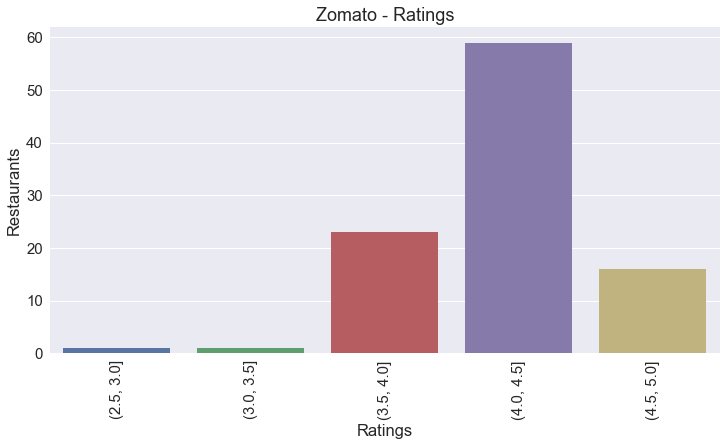

In [64]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=zomato)
plt.title('Zomato - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

# Yelp Rating

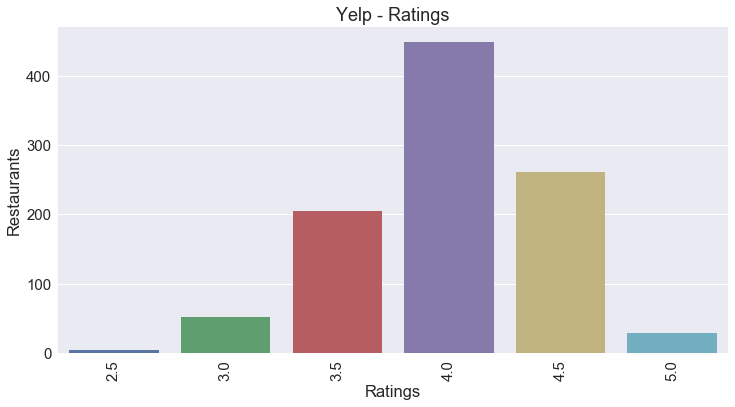

In [65]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='rating', data=yelp)
plt.title('Yelp - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

## Yelp Price

In [66]:
yelp = yelp.sort_values('price', ascending=False)

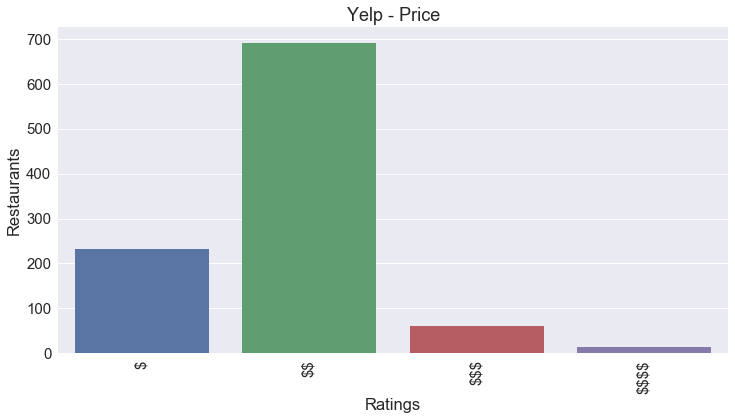

In [67]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='price', data=yelp)

ax = plt.gca()

ax.set_xticklabels(['\$','\$$','\$$\$', '\$\$\$$'])
plt.title('Yelp - Price')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')

plt.xticks(rotation=90)
plt.show()

## Top 20 Restaurant Categories and their Rating

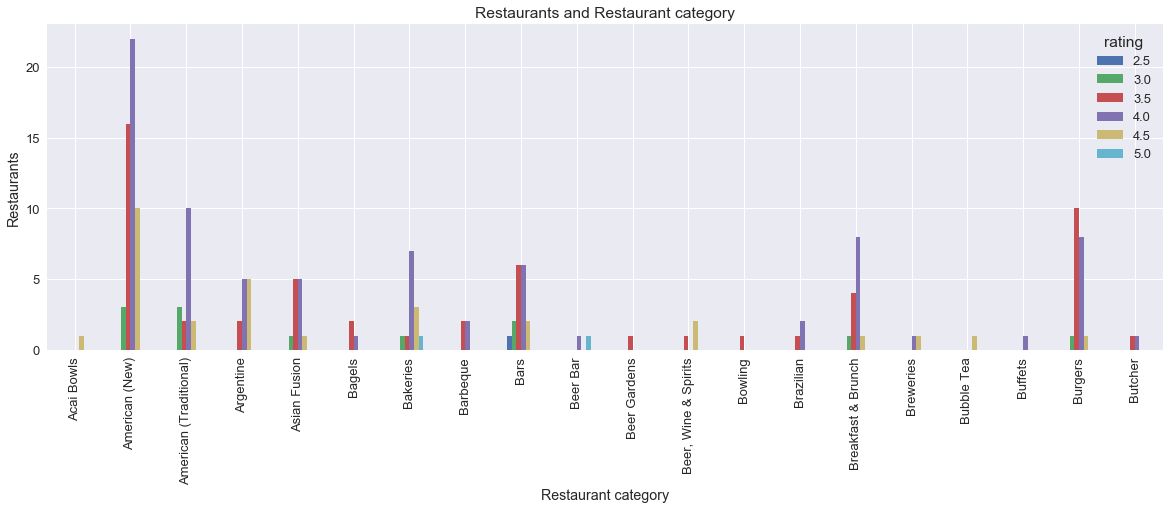

In [68]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.category,yelp.rating).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

## Top 20 Restaurant Categories and their Price

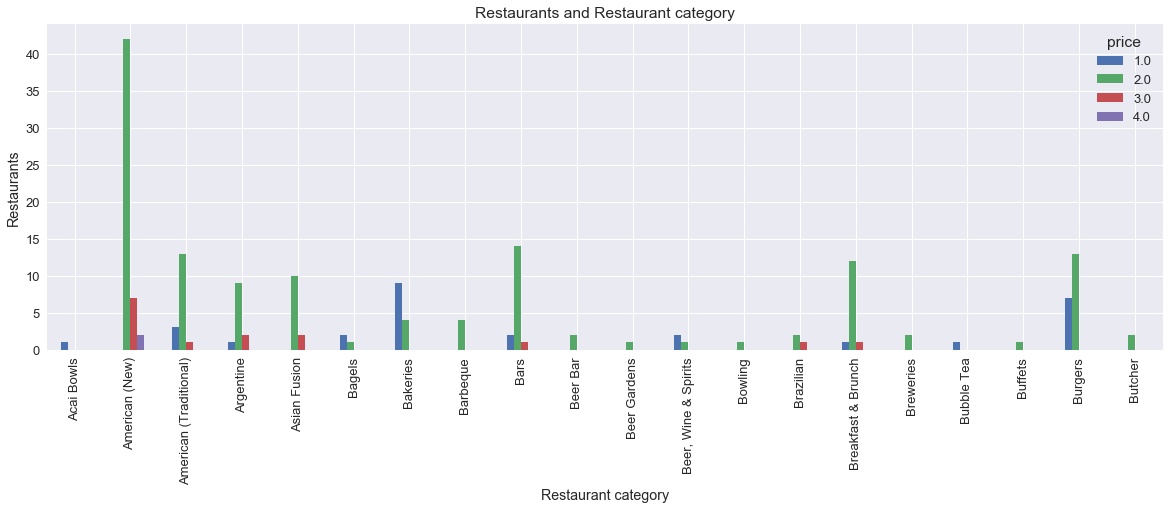

In [69]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.category,yelp.price).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Trip Advisor

In [71]:
# There are in total 3600 restaurants
ta.rating.str[-5:].unique()

array(['3,600', nan], dtype=object)

# Converting the restaurant ranking to rating

In [72]:
# Extracting the ranking for each restaurant

ta['rating'] = ta.rating.str.split(' ').str[0].str.replace(',','')

In [73]:
# Dividing the restaurants on a scale of 3,600 total restaurants in Miami

ta['rating'] = ta['rating'].astype(float)/3600

In [74]:
# Converting to a 5-scale

ta['ratingpercentile'] = pd.qcut(ta.rating,100, labels=False)

In [75]:
ta['ratingbucket'] = np.where(ta.rating.isnull(), np.nan, 5.0)

# Top 10 percentile with rating 5
ta['ratingbucket'][ta['ratingpercentile'] > 10] = 4.5
# 10-30 percentile with 4.5
ta['ratingbucket'][ta['ratingpercentile'] > 30] = 4.0
# 30 -60 with 3.5
ta['ratingbucket'][ta['ratingpercentile'] > 60] = 3.5
# 60 - 80 with 3.0
ta['ratingbucket'][ta['ratingpercentile'] > 80] = 3.0
# 80 - 90 with 2.5
ta['ratingbucket'][ta['ratingpercentile'] > 90] = 2.5

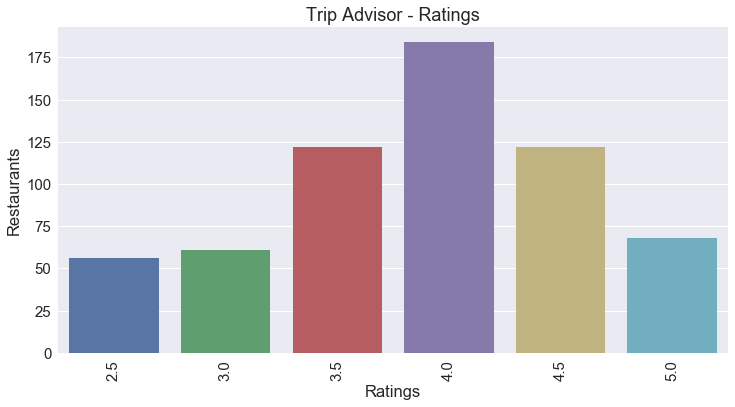

In [76]:
ta = ta.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=ta)
plt.title('Trip Advisor - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

In [112]:
zomato.columns = ['zomato_category','name','zomato_price','zomato_rating','zomato_review_count','zomato_url'
       ,'zomato_zip','zomato_source','zomato_ratingbucket']

In [120]:
yelp.columns = ['yelp_category', 'name','yelp_price','yelp_rating','yelp_review_count','yelp_url','yelp_zip','yelp_source']

In [114]:
ta.columns = ['name','ta_url','ta_category','ta_zip','ta_price',
       'ta_review_count', 'ta_source', 'ta_rating', 'ta_ratingpercentile', 'ta_ratingbucket']

In [121]:
comb = pd.merge(ta, zomato, how = 'inner', on = 'name')

comb.shape

(3, 18)

In [122]:
comb2 = pd.merge(comb, yelp, how = 'inner', on = 'name')

comb2.shape

(4, 25)

## Rating comparison Yelp vs Ta vs Zomato

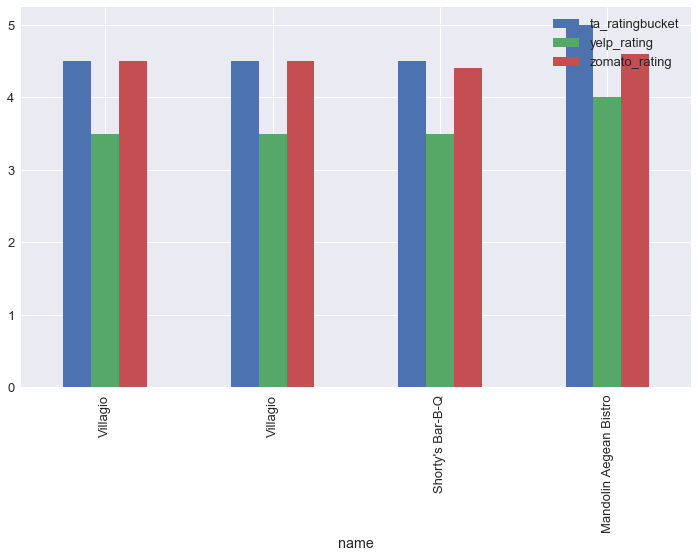

In [123]:
sns.set(font_scale=1.3)

comb2.plot(kind='bar', x = 'name',y = ['ta_ratingbucket','yelp_rating','zomato_rating'], figsize=(12,7))

plt.show()

## Rating comparison Yelp vs Zomato

In [124]:
comb3 = pd.merge(zomato, yelp, how = 'inner', on = 'name')

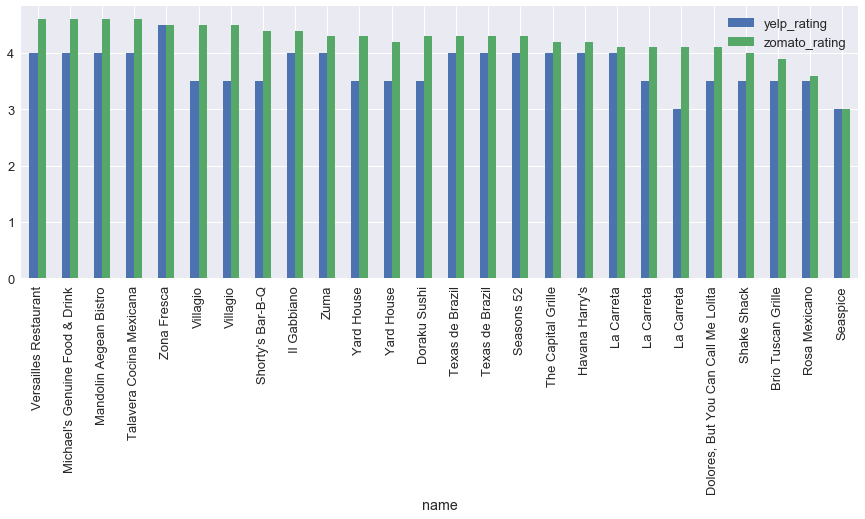

In [125]:
sns.set(font_scale=1.3)

comb3.plot(kind='bar', x = 'name',y = ['yelp_rating','zomato_rating'], figsize=(15,5))

plt.show()

## Word Cloud by Zip code

In [102]:
df_reviews= pd.read_csv("../DataFiles/reviews_df.csv")

In [103]:
def datacleaning(df):
    #removing @
    df["reviews"]= df.apply(lambda row: re.sub(r'@[\w0-9]+','',row["reviews"],re.IGNORECASE), axis=1)
    #removing URL tags
    df["reviews"]= df.apply(lambda row: re.sub(r'https?://[\w0-9./]+','',row["reviews"],re.IGNORECASE), axis=1)
    df["reviews"]= df.apply(lambda row: re.sub(r'www.[^ ]+','',row["reviews"],re.IGNORECASE), axis=1)
    
    #removing Byte order marks
    df["reviews"]= df.apply(lambda row: row["reviews"].replace(u"\ufffd", "?"), axis=1)
    #Convert the data to lowercase
    df["reviews"]= df.apply(lambda row: row["reviews"].lower(), axis=1)    
    #removing hashtag/numbers and punctuations
    df["reviews"]= df.apply(lambda row: re.sub(r"[^a-zA-Z ]+",'',row["reviews"]), axis=1)
    return df
df_reviews = datacleaning(df_reviews)

In [128]:
def handle_length(text):
    tokenizer = nltk.tokenize.word_tokenize
    words = tokenizer(text)
    fin=[]
    for word in words:
        if len(word)>1:
            fin.append(word)
    return " ".join(fin)    
df_reviews["reviews"] = df_reviews["reviews"].apply(handle_length)

In [108]:
def filter_data_byzip(df,zip_code):
    df_ = df.copy()
    df_ = df_[df_["zip"]==zip_code]
    return " ".join(list(df_["reviews"]))

# Please select a zip code from the below list

In [109]:
##Run the code to generate a list of zip codes unique to Miami

df_reviews["zip"].unique()

array([33135, 33134, 33127, 33132, 33128, 33143, 33137, 33133, 33131,
       33138, 33176, 33173, 33165, 33130, 33145, 33183, 33174, 33144,
       33155, 33126, 33156, 33172, 33136, 33125, 33122, 33166, 33186,
       33175, 33146, 33150, 33010, 33231, 33129, 33184, 33142, 33178,
       33196, 33147, 33101, 33256, 33149, 33255])

Enter the Zipcode:33149


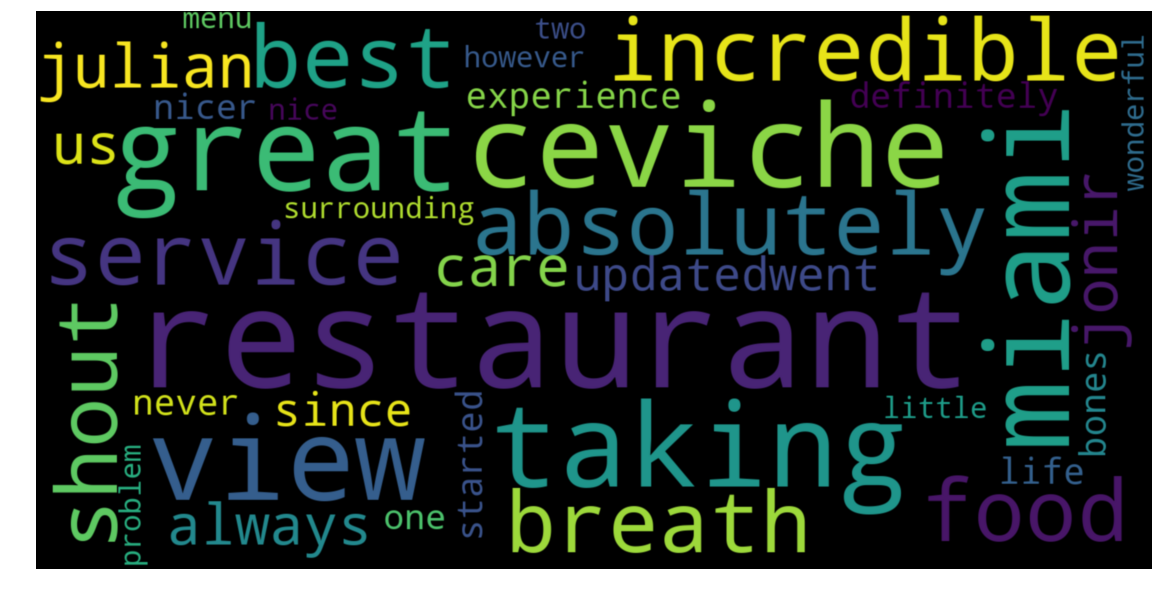

In [126]:
##The below block of code asks you to enter a zipcode, based on which it generates a wordcloud for the ZIPCODE

val = int(input("Enter the Zipcode:"))

reviews_list= filter_data_byzip(df_reviews,val)
if len(reviews_list)!=0:
    wc = WordCloud(width=1600, height=800,max_font_size=200,stopwords=nltk.corpus.stopwords.words('english')\
                         , colormap="viridis").generate(reviews_list)
    plt.figure(figsize=(20,18))
    plt.imshow(wc, interpolation="bicubic")
    plt.axis("off")
    plt.show()
else:
    print("enter the zip code in the list")
    

# Thank You!